# Image classification on IKEA Dataset

In [1]:
#importing neccesary libraries
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


In [2]:
train_dir = './dataset/train'
validation_dir = './dataset/val'
image_size = 224

Load a pretrained model on imagenet dataset and adjust last fully connected layers. 

In [4]:
from keras.applications import MobileNet

#Load the MobileNet model
mobilenet_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in mobilenet_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(mobilenet_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(4, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 4100      
Total para

Found 991 images belonging to 4 classes.
Found 317 images belonging to 4 classes.
Epoch 1/50
40/39 [==============================] - 15s 374ms/step - loss: 2.5733 - acc: 0.3996 - val_loss: 0.6441 - val_acc: 0.7445
Epoch 2/50
40/39 [==============================] - 12s 307ms/step - loss: 1.4340 - acc: 0.5944 - val_loss: 0.5302 - val_acc: 0.7886
Epoch 3/50
40/39 [==============================] - 13s 317ms/step - loss: 1.0792 - acc: 0.6581 - val_loss: 0.4808 - val_acc: 0.8107
Epoch 4/50
40/39 [==============================] - 12s 312ms/step - loss: 0.9112 - acc: 0.7088 - val_loss: 0.4371 - val_acc: 0.8360
Epoch 5/50
40/39 [==============================] - 13s 315ms/step - loss: 0.7585 - acc: 0.7571 - val_loss: 0.4265 - val_acc: 0.8423
Epoch 6/50
40/39 [==============================] - 13s 315ms/step - loss: 0.6962 - acc: 0.7743 - val_loss: 0.4042 - val_acc: 0.8454
Epoch 7/50
40/39 [==============================] - 13s 318ms/step - loss: 0.5577 - acc: 0.7907 - val_loss: 0.4012 - val

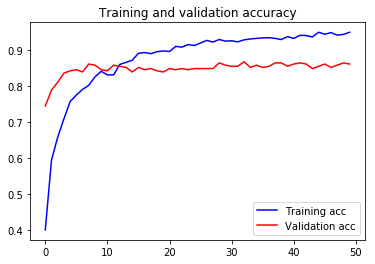

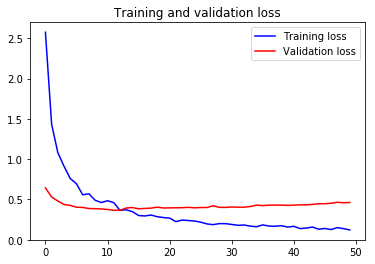

In [6]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical',
        shuffle=True)

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=True)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2*train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save('model.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 317 images belonging to 4 classes.
16/15 [==============================] - 1s 46ms/step
No of errors = 44/317


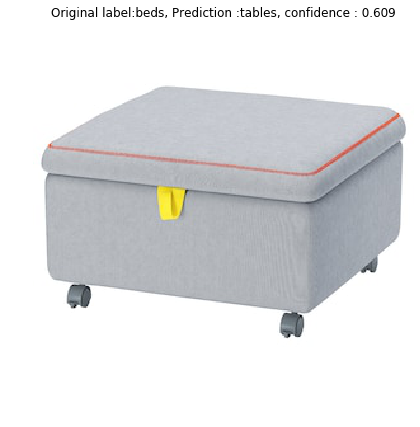

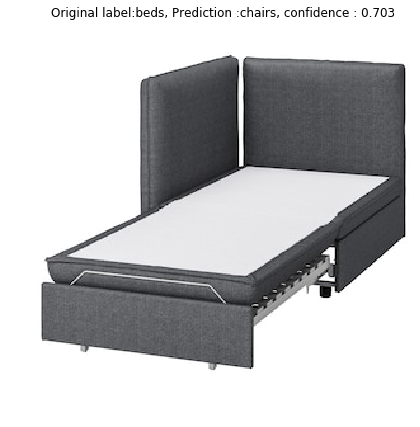

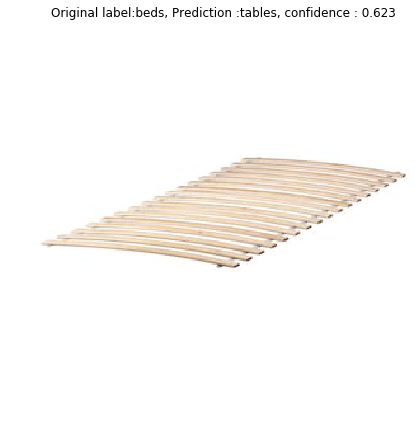

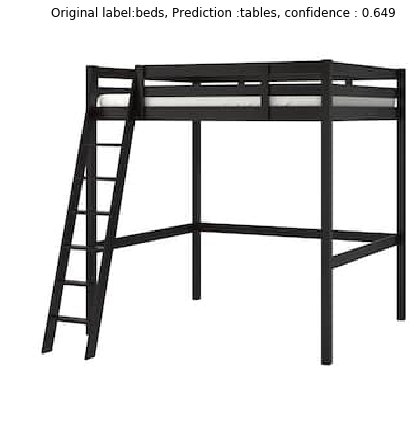

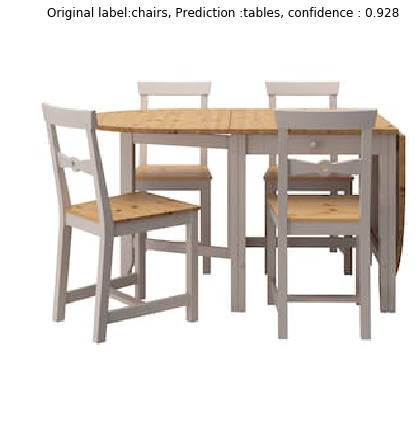

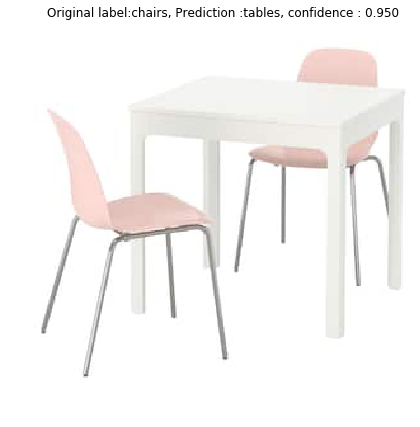

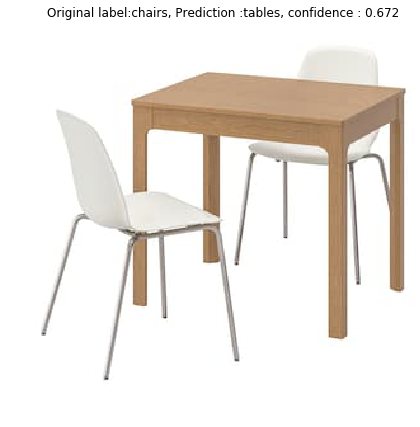

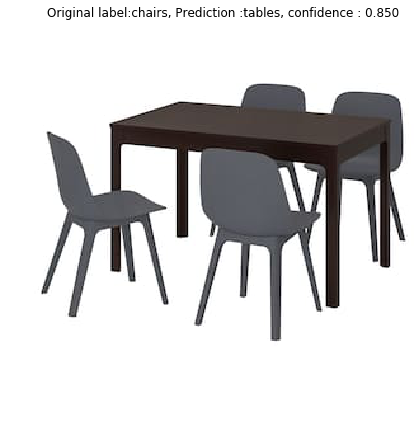

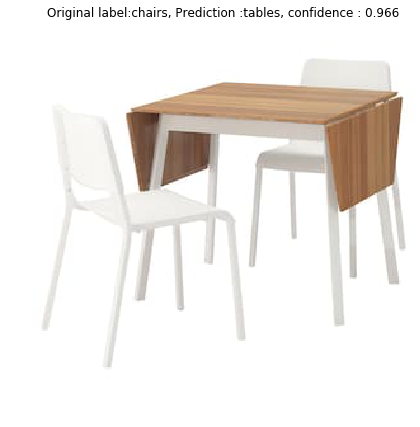

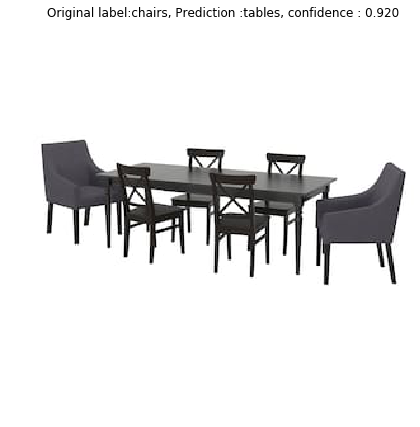

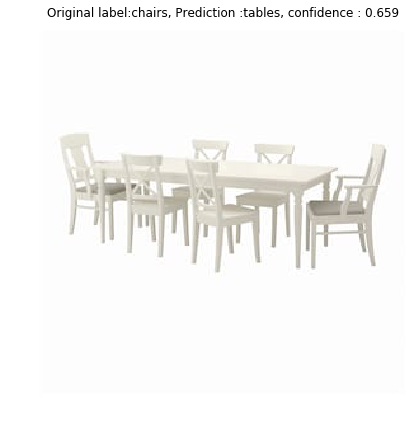

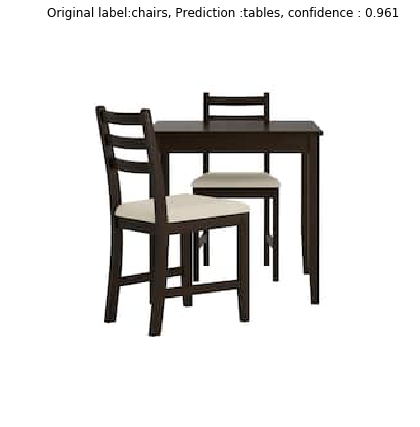

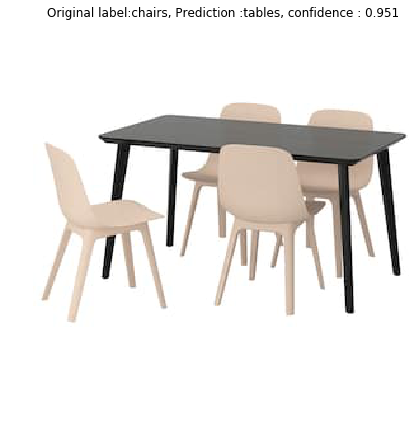

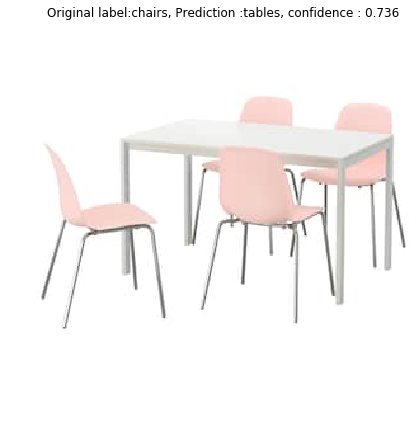

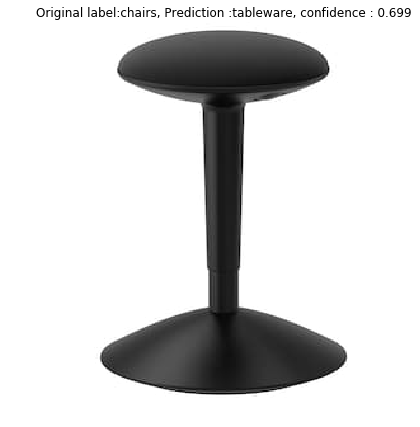

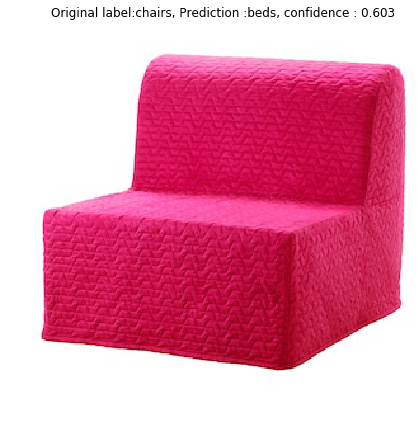

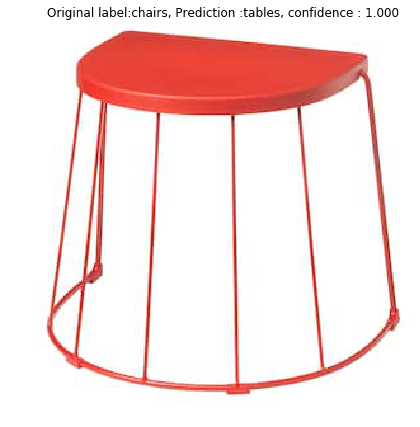

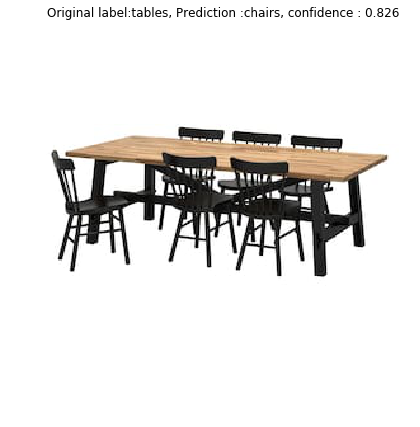

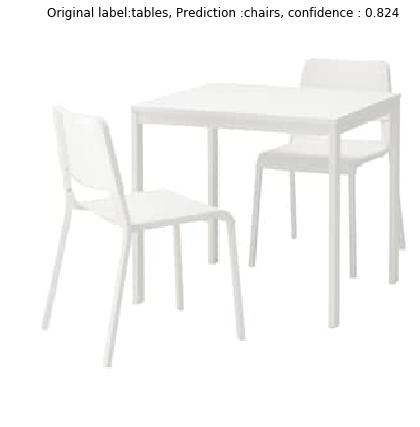

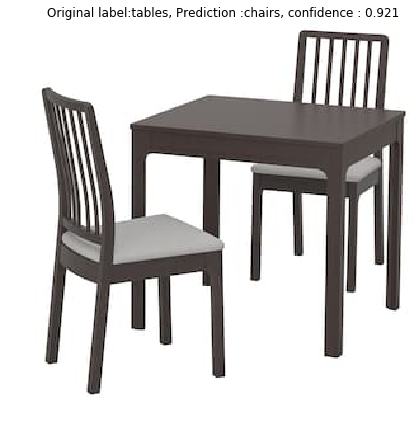

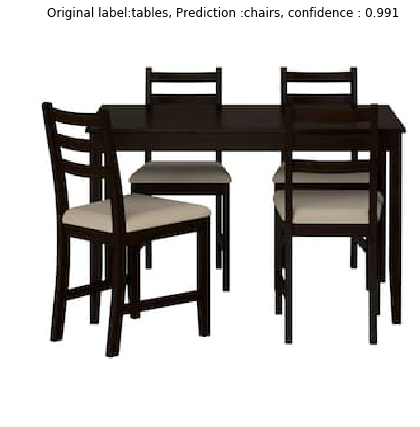

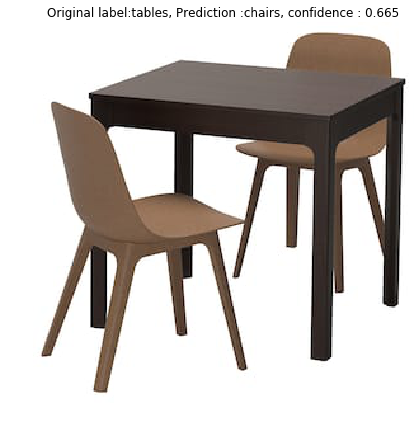

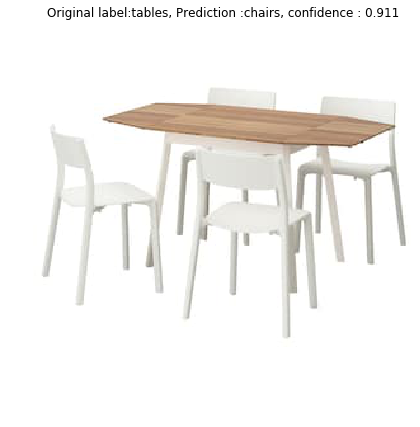

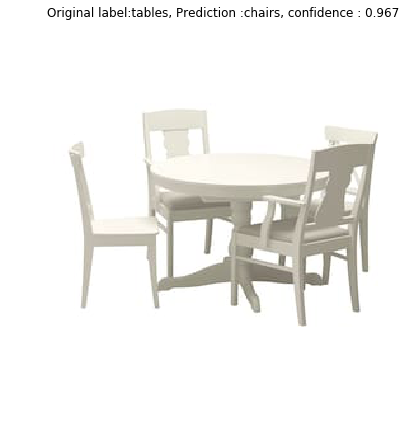

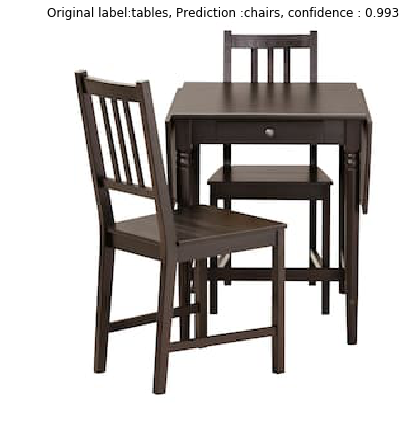

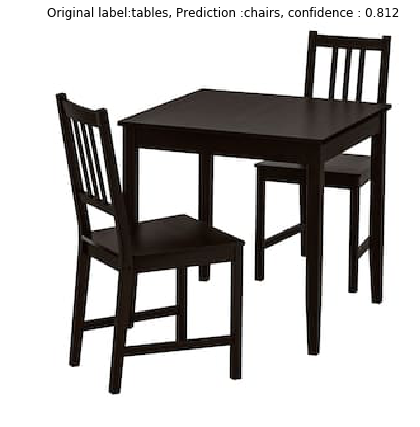

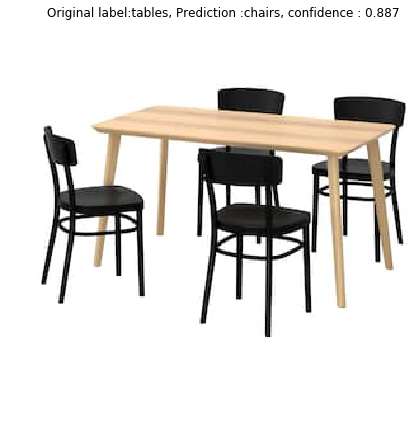

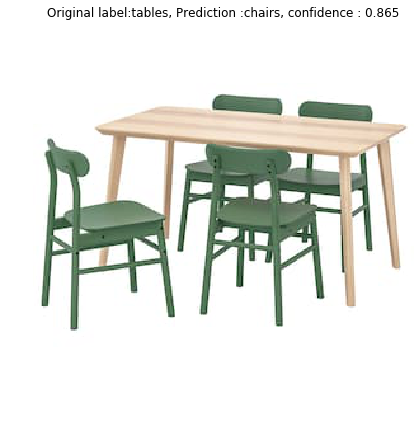

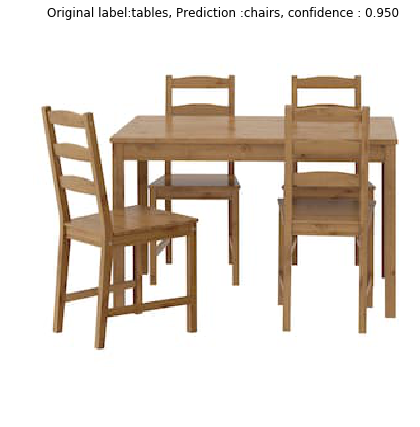

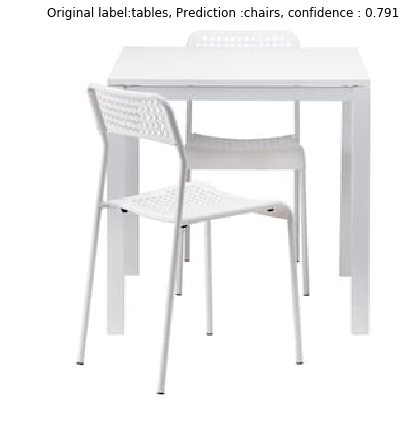

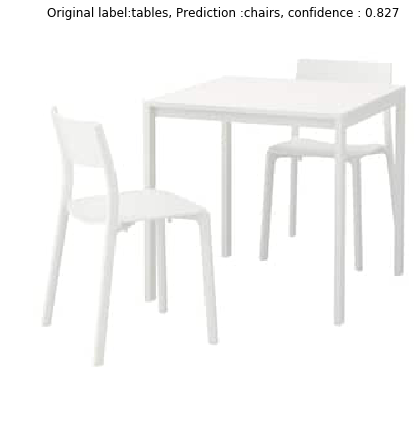

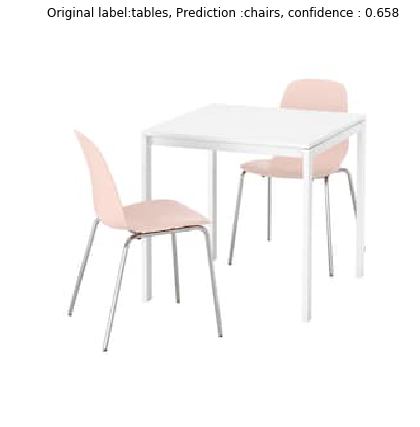

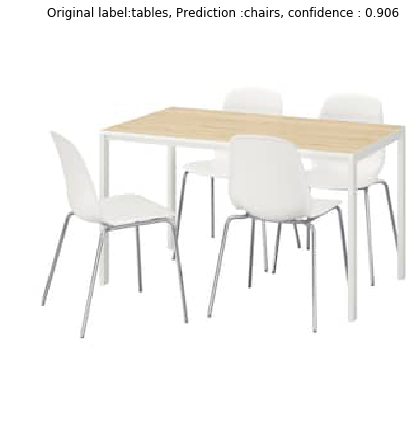

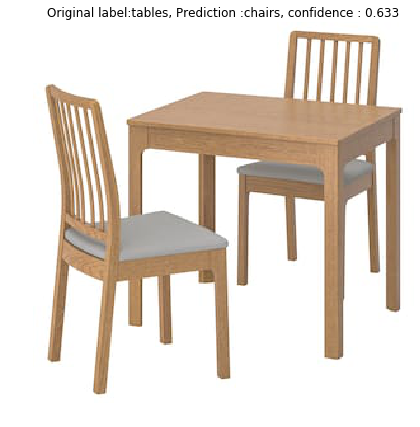

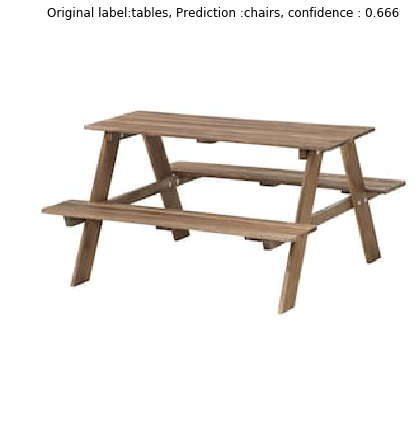

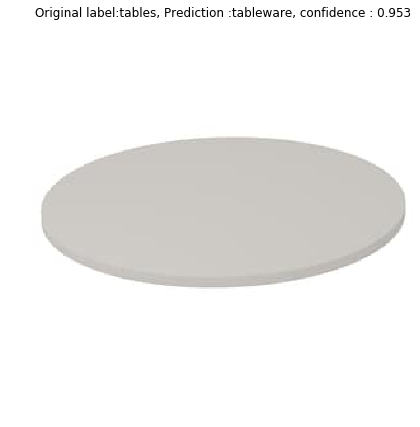

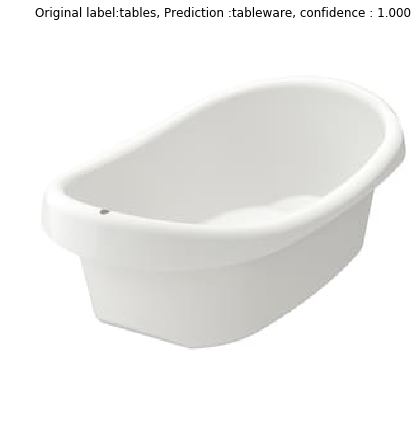

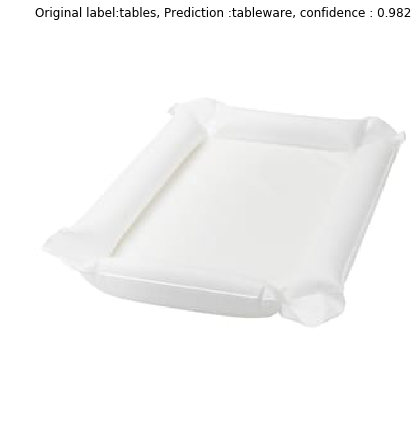

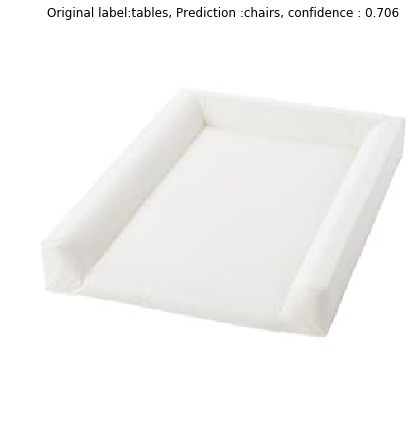

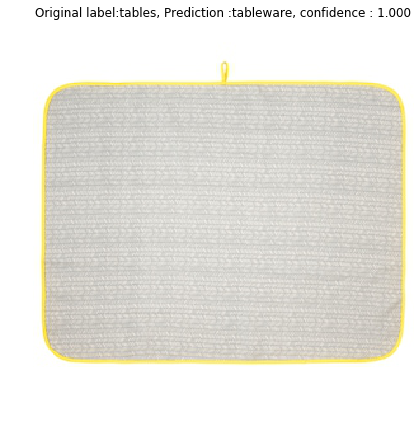

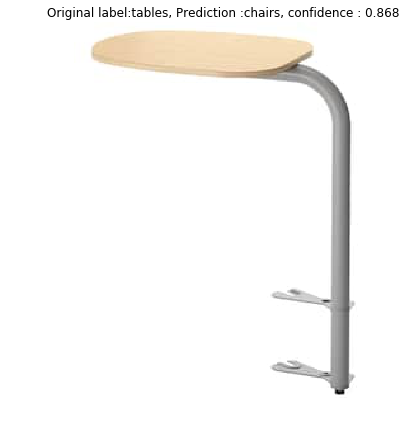

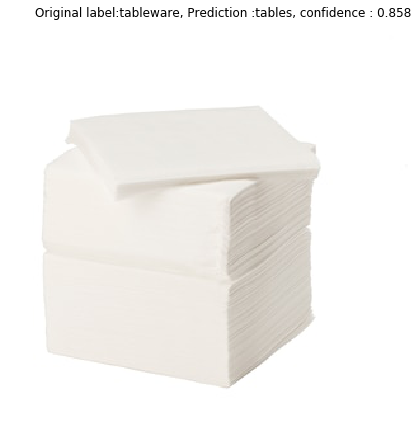

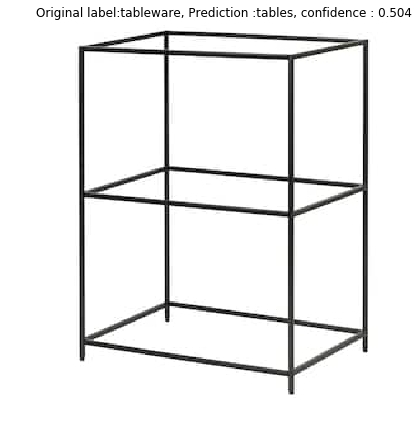

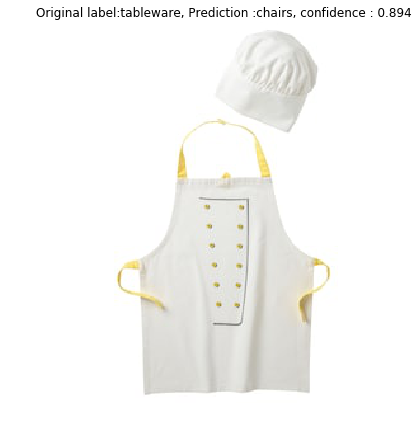

In [7]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [8]:
test_dir = './dataset/test'
# Create a generator for prediction on test data
test_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
correct = np.where(predicted_classes == ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
print("No of correct = {}/{}".format(len(correct),test_generator.samples))
y_pred = []
y_true = []


Found 132 images belonging to 4 classes.
7/6 [===============================] - 0s 37ms/step
No of errors = 23/132
No of correct = 109/132


Saving the predicted labels and actual labels in a list to calculate the confusion matrix.

In [9]:
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    y_true.append(fnames[errors[i]].split('/')[0])
    y_pred.append(pred_label)

In [10]:
for i in range(len(correct)):
    pred_class = np.argmax(predictions[correct[i]])
    pred_label = idx2label[pred_class]
    
    y_true.append(fnames[correct[i]].split('/')[0])
    y_pred.append(pred_label)

In [11]:
# Function to calculate and plot the confusion matrix
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.96296296 0.         0.03703704 0.        ]
 [0.         0.59375    0.3125     0.09375   ]
 [0.02941176 0.14705882 0.76470588 0.05882353]
 [0.         0.         0.02564103 0.97435897]]


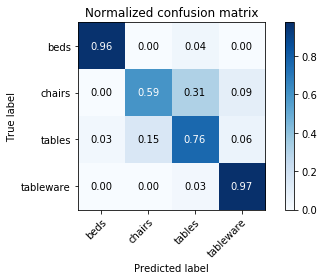

In [12]:
plot_confusion_matrix(y_true,y_pred, ["beds", "chairs", "tables", "tableware"],True)